# The basics of making a moving sound... 
### (1) a simple sine wave x a simple envelope
### (2) calculate the position in time of the beep source
### (3) calculate the weights for each channel for that sound (stereo and 4 channel)
### (4) create the sound channels and add weighted beeps at times. 
### (5) listen 
### (6) ways to add to this ! 

In [287]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt # for plots

from scipy import fftpack as spfft # for computing spectra
#from scipy import signal as spsig
import librosa

# our codes: 
import sys
sys.path.append('./position_generator/')
import position_generator as pos_gen
from importlib import reload   # reload it below
 
% matplotlib inline

In [288]:
#make a function to make a single frequency beep...  

def make_beep(dur,f,sr):
    p = 1/f
    n_cycles = dur/p
    n_pts = int(np.floor(dur*sr))
    
    t = np.linspace(0,dur,n_pts)
    #osc = exp**(jj*t) # the other way... useful..     
    x = np.linspace(0,2*np.pi*n_cycles,n_pts) # radians, not time ! but also is time. 
    y_osc = np.sin(x) 
    
    return t,y_osc

def make_env_tri(t,peak_pos_01):
    N = len(t)
    env = np.zeros(N)
    peak_ind = int(np.floor(peak_pos_01*N))
    
    # from 0 to the peak index (peak):
    up = np.linspace(0,1,peak_ind)
    env[:peak_ind] = up
    # and fill in the rest: 
    down = np.linspace(1,0,(N-peak_ind))
    env[peak_ind:] = down
    
    return env

In [291]:
# make the waveform and envelope for one beep. 
# make vectors of two frequencies, that have the same number of points, long enough to hear

dur = 0.3 # in seconds
sr = 44100 # samples/sec
f = 600. # frequency
peak_pos_01 = 0.2 # where the peak of the triangular envelope is
a_scale = 0.8

t,y_osc = make_beep(dur,f,sr)
env = make_env_tri(t,peak_pos_01)
# modulate the signal by multiplication
env = env*a_scale
y = y_osc*env

print(len(y))

13230


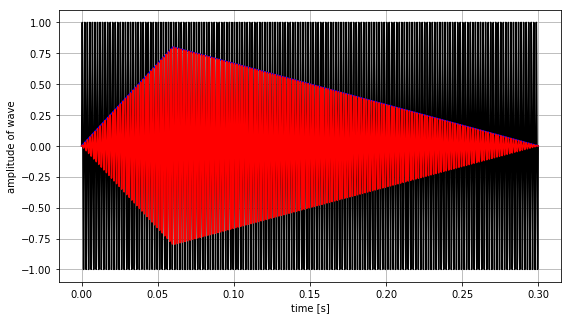

In [292]:

# plot the wave
plt.figure(figsize=(9,5))
plt.plot(t,y_osc,'k') 
plt.xlabel('time [s]')
plt.ylabel('amplitude of wave')
plt.grid()

# plot the envelope
plt.plot(t,env,'b') 
plt.plot(t,y,'r') 
plt.xlabel('time [s]')
plt.ylabel('amplitude of wave')

# write the sound: 
outfile = 'sound_1env.wav'
librosa.output.write_wav(outfile, y, int(sr), norm=False)

### add complexity to the beep
#### Zhouyao, here is one place we can add to-- the ability to locate sound depends on the quality of the sound ! We can add beeps on top of beeps to construct more complex sounds (eventually to simulate what earthquakes sound like ! 

In [44]:
# # concatenating

# print(y2.shape)
# yc = np.concatenate((y1,y2),axis=0)
# outfile = 'sound_conc.wav'
# fs = int(1/dt) # must be an integer ! 
# a_scale = 0.6
# librosa.output.write_wav(outfile, yc*a_scale, fs, norm=False)

## (5) Looking at the sound: The Fourier Transform ! 

(0, 7350.0)

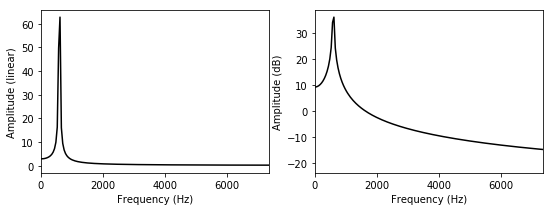

In [315]:

########## First do the Fourier transform = look at the frequency content of the entire signal
# We do a fast Fourier transform (FFT)

Nfft = 1000 # Number of points (discrete frequencies) on which to compute the FFT 
# (actually twice the number of frequency point we need, but that's another story). Better if it's a power of 2
f = np.arange(-Nfft/2,Nfft/2,1)*sr/Nfft 
# the discretized vector of frequencies: contains negative and positive frequencies 
# (see mathematical definition of the Fourier transform)

# FFT computation -> gives the spectrum S
S = spfft.fft(y, n=Nfft)
# S is an array of complex numbers, containing the amplitude for each frequency bin in f, but in another order... 
# First positive frequency bins, then negative frequency bins...

# Let's consider only positive frequencies
f = f[int(len(f)/2):] 
S = S[:int(len(S)/2)] 
# Now f covers the (discretized) frequency range from 0 to sr/2 Hz (see Nyquist theorem, Nyquist frequency)

########## Finally plot the spectrum
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(f,np.absolute(S),'k') # Since S is complex-valued, we have to choose between the absolute value and phase
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (linear)')
plt.xlim([0,sr/6])
plt.subplot(1,2,2)
#plt.figure(figsize=(9,5))
plt.plot(f,20*np.log10(np.absolute(S)),'k') # Take the log10 with numpy, and have a factor 20 because we're dealing with acoustic pressure (L = 20log10(p/pref)) and not intensity (L = 10log10(p/pref))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.xlim([0,sr/6])

## (5) Looking at the sound: The Spectrogram ! 

The "problem" with FFT is that it averages the frequency content over the whole signal. We completely lose the 
information of time.

so... Short Term Fourier Transform (STFT).

The idea is to cut the signal into successive time frames and perform an FFT for each frame
Involves quite a bit of mathematical stuff which we will ingeniously skip here...

See here for a graphical explanation https://www.researchgate.net/figure/231828310_fig7_Figure-7-Short-time-Fourier-transform-STFT-with-envelope-and-two-sample-overlap

And the well-known "spectrogram" is only a graphical representation of the STFT. 

Text(0,0.5,'dB')

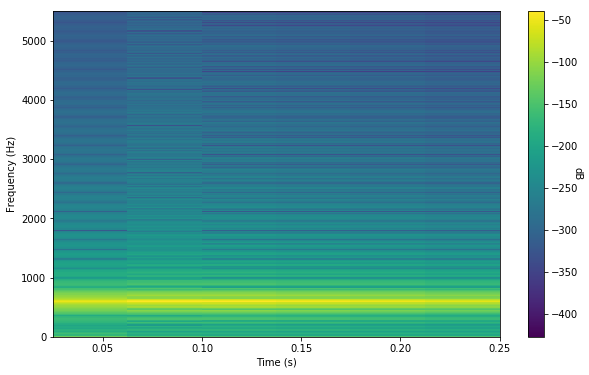

In [294]:
from scipy import signal as spsig

# Let's compute the spectrogram
NfftSTFT = 4096 # The number of frequency points for the FFT of each frame
SliceLength = int(0.05*sr) # The length of each frame (should be expressed in samples)
Overlap = int(SliceLength/4) # The overlapping between successive frames (should be expressed in samples)
[fSTFT, tSTFT, STFT] = spsig.spectrogram(y, fs=sr, nperseg=SliceLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!

# Let's plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,sr/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

# MOTION OF BEEPS ! 
### Zhouyao's code

In [316]:
reload(pos_gen)

pos_gen.initialize(0)
list = [0,2,1,3,2,1,0]
pos_gen.move(list)
s = pos_gen.s
print(s.shape)
npos = len(s)


# Zhouyao, it took me a bit of time to figure out the structure of the s output, as a single pd.Series, 
# not a data frame with two columns.. its ok, but might be more transparent to write it as a dataframe, 
# with a separate one for the parameters used to generate the positions and time, 
# as the data gets more complex. We can think about this later. 


print(type(s))
# print(s[:][0])
# print(s.index[-1])
# print(s.loc[s.index[-1]])

# d = s.to_frame(['time','position'])
# print(d.columns)

# or reading the pickles: 
# posdf = pd.read_pickle('./position_generator/position_data_1.pickle')
# posdf.shape

(162,)
<class 'pandas.core.series.Series'>


In [304]:
# this is what i did to extract the time and position data: 

time = np.ndarray(npos)
posn = np.ndarray(npos)

for i in range(npos):
    time[i] = s.index[i]
    posn[i] = s.loc[s.index[i]]

print(len(time))
dur_track = time[-1]
print('dur_track (total duration of sound) = ', str(dur_track))
# subsample to get beep times ! 
subsam = 3
time_beep = time[0::subsam]
posn_beep = posn[0::subsam]


162
dur_track (total duration of sound) =  16.1


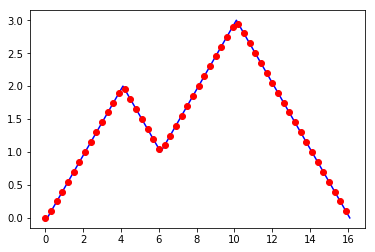

In [305]:
plt.plot(time,posn,'b') 
plt.plot(time_beep,posn_beep,'ro') 

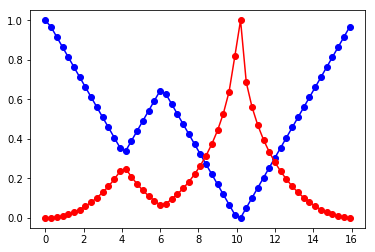

In [298]:
# make the scale factors or weights W for amplitude by position
# stereo version: 
posn_beep = posn_beep/max(posn_beep)

left_distance = posn_beep # np.sqrt(0**2 + posn_beep**2) 
W_left = 1 - left_distance 

right_distance = np.sqrt(1 - posn_beep**2 ) # np.sqrt(1**2 - posn_beep**2 ) 
W_right = 1 - right_distance 

#W_left = np.zeros(len(posn_beep))
#W_right = np.zeros(len(posn_beep))

plt.plot(time_beep,W_left,'b-') 
plt.plot(time_beep,W_left,'bo') 
plt.plot(time_beep,W_right,'r-') 
plt.plot(time_beep,W_right,'ro') 


In [306]:
# make the time series of weighted beeps ! 
dt_extra = 1.0 # time to add on to the end for the last beep
n_samp = int((dur_track+dt_extra)*sr)

# make a sounds track of zeros :   (# alternative: concatenate, but that's more complicated) 
time_sound = np.linspace(0,dur_track+dt_extra,n_samp)
channel_left = np.zeros(n_samp) 
channel_right = np.zeros(n_samp) 

print(channel_left.shape)
print(time_sound)

(754110,)
[  0.00000000e+00   2.26757670e-05   4.53515341e-05 ...,   1.70999546e+01
   1.70999773e+01   1.71000000e+01]


In [307]:
# function to find the location in the time vector of where each beep will be added to the sound

def find_first_t(time_sound, t_bp):
    ind = np.argmax(time_sound>t_bp)
    return ind

# other ways: 

        #if t_bp > t: 
        #    break
    #return time_sound.index(i_t)
       
# or this: 
# bisect_left(alist, value)  
# experiment with this later

In [308]:

for i_samp, t_samp in enumerate(time_beep):
    #print(t_samp)
    # find where in the time_sound each time_beep occurs: 
    i_bp = find_first_t(time_sound, t_samp)
    #print(i_bp)
    
    # make beep
    # for now, nothing is changing with the beep other than the weight determined here, 
    # so we can just use the curve defined above instead of re-calling the functions. 
    # to change pitch or duration or whatnot, the make_beep function would be called here. 
    
    w_l = W_left[i_samp]
    y_w_l = y*w_l
    
    w_r = W_right[i_samp]
    y_w_r = y*w_r
    # add it to the soundtracks (l + r)
    channel_left[i_bp:i_bp+len(y_w_l)] = y_w_l
    channel_right[i_bp:i_bp+len(y_w_r)] = y_w_r

    
#W_right

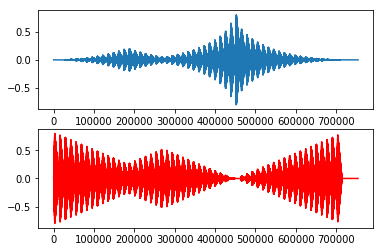

In [309]:
plt.subplot(2,1,1)
plt.plot(channel_right)
plt.subplot(2,1,2)
plt.plot(channel_left, 'r')

In [310]:
# merge into one array to make sound file
# [2,:]
print(len(channel_right))
snd = np.zeros([2,len(channel_right)])
print(snd.shape)
snd[0,:] = channel_left
snd[1,:] = channel_right

754110
(2, 754110)


In [311]:
#plt.plot(snd[0,:])

# write the sound: 
outfile = 'sound_moving_stereo.wav'
librosa.output.write_wav(outfile, snd, int(sr), norm=False)